### Notebook to investigate similarity (rot-invariance) on each layer

In [2]:
%matplotlib inline
import os
import cv2
import gc
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.data import parallel_interleave

In [147]:
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
from tensorflow.python.keras.models import Model

In [4]:
import math
import pickle
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity 

In [6]:
def data_extractor_resize_fn(filelist,prefetch=1,height=32,width=32,channel=6,read_threads=4, distribute=(1, 0)):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        # conversion of tensor
        patch = tf.cast(patch, tf.float32)
        patch = tf.image.resize_images(patch, (height, width))
        return patch
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patches_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch = sess.run(next_element)
                patches_list.append(patch)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patches_list

In [7]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

#### Load dataset

In [8]:
#tf_datadir = "/project2/foster/clouds/data/clouds_laads_multiprocessed_2000_2018_band28_29_31_circle_2" # midway
tf_datadir = "/home/tkurihana/Research/data/tfrecords/clouds_laads_multiprocessed_2000_2018_2"
filelist = glob.glob(os.path.join(tf_datadir, '2-10*.tfrecord'))

In [10]:
## load 
nfiles = 1
fdx = np.random.randint(0,len(filelist),nfiles)
patches_list = []
for ifile in [filelist[i] for i in fdx]:
    patches_list.append(data_extractor_resize_fn([ifile],height=32,width=32,channel=6 ))
print("NORMAL END")

## get patch
height = width = 32
channel = 6
patches = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,height,width, channel) for i in patches_list[0]],
    axis=0)
print(patches.shape)

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process
NORMAL END
(2000, 32, 32, 6)


#### Load Encoder and Decoder

In [14]:
# 67011582; Best model
#model_datadir = '/home/tkurihana/rotate_invariant/stepbystep/transform/output_model'
model_datadir = '/home/tkurihana/Research/models'
expname = 67011582
model_dir = os.path.join(model_datadir,str(expname) )
encoder = load_latest_model(model_dir, mtype='encoder')
decoder = load_latest_model(model_dir, mtype='decoder')

 Load encoder at 100 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
 Load decoder at 100 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
# Check layer names
layer_names = [layer.name for layer in encoder.layers]

In [16]:
layer_names

['encoding_input',
 'conv2d',
 'leaky_re_lu',
 'conv2d_1',
 'leaky_re_lu_1',
 'conv2d_2',
 'leaky_re_lu_2',
 'conv2d_3',
 'batch_normalization',
 'leaky_re_lu_3',
 'conv2d_4',
 'leaky_re_lu_4',
 'conv2d_5',
 'leaky_re_lu_5',
 'conv2d_6',
 'batch_normalization_1',
 'leaky_re_lu_6',
 'conv2d_7',
 'leaky_re_lu_7',
 'conv2d_8',
 'leaky_re_lu_8',
 'conv2d_9',
 'batch_normalization_2',
 'leaky_re_lu_9',
 'conv2d_10',
 'leaky_re_lu_10',
 'conv2d_11',
 'leaky_re_lu_11',
 'conv2d_12',
 'batch_normalization_3',
 'leaky_re_lu_12',
 'conv2d_13',
 'leaky_re_lu_13',
 'conv2d_14',
 'leaky_re_lu_14']

In [10]:
layer_name = encoder.get_layer('leaky_re_lu_14')

#### Select patches for less memory

In [17]:
spatches = patches[:100]
spatches.shape

(100, 32, 32, 6)

#### Copy and Rotate

In [18]:
def rotate_fn(images, angles):
    """
    images : 4d tensor [batch, height, width channel]
      original oprion - nearest. Additional: biilnear
    """
    rotated_tensor_images = tf.contrib.image.transform(
      images,
      tf.contrib.image.angles_to_projective_transforms(
        angles, tf.cast(tf.shape(images)[1], tf.float32), 
            tf.cast(tf.shape(images)[2], tf.float32)
        ),
    )
     #interpolation='BILINEAR'
    return rotated_tensor_images

In [19]:
def copy_rot_fn(patches, height=None, width=None, ch=None, copy_size=None):
    img_list = []
    for patch in patches:
        img_list.extend([np.reshape(patch, (1,height,width,ch))])
        img_list.extend([ np.expand_dims(np.copy(patch.reshape(height,width,ch)), axis=0) 
                     for i in range(copy_size-1)])
    imgs = np.concatenate(img_list, axis=0)
    print(imgs.shape)
    
    radians = []
    for j in range(patches.shape[0]):
        radians.extend([i*math.pi/180 for i in np.linspace(0,360,copy_size+1) ][:-1] )
    print(len(radians))
    rimgs_tf = rotate_fn(imgs, angles=radians)
    rtest_imgs = tf.keras.backend.eval(rimgs_tf)
    del imgs, rimgs_tf
    return rtest_imgs


In [20]:
#### CONFIG ####
_, h,w,c, = spatches.shape
copy_size = 12

In [21]:
rpatches = copy_rot_fn(spatches, height=h, width=w, ch=c, copy_size=copy_size)
rpatches.shape

(1200, 32, 32, 6)
1200


(1200, 32, 32, 6)

### Investigate "Invariance" layers

#### Get layers from decoder where rotation invariant is acheived 

In [22]:
decoder_results = {}
model = decoder

### processing ###
layer_names = [layer.name for layer in model.layers]
encs = encoder.predict(rpatches)
for layer_name in layer_names[1:]:
    tmp = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
    decoder_results[layer_name] = tmp.predict(encs)

In [23]:
### Check layer sizes
for ikey in decoder_results.keys():
    print(decoder_results[ikey].shape)

(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 6)
(1200, 32, 32, 6)


In [24]:
#https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict
with open('./decoder_results_100.pkl', 'wb') as handle:
    pickle.dump(decoder_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Get layers from Encoder:  To check cosine similarity 

In [25]:
encoder_results = {}
model = encoder

### processing ###
layer_names = [layer.name for layer in model.layers]
#encs = encoder.predict(rpatches)
for layer_name in layer_names[1:]:
    tmp = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
    encoder_results[layer_name] = tmp.predict(rpatches)

In [26]:
### Check layer sizes
for ikey in encoder_results.keys():
    print(encoder_results[ikey].shape)

(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 32, 32, 32)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 16, 16, 64)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 8, 8, 128)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 4, 4, 256)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)
(1200, 2, 2, 512)


In [27]:
with open('./encoder_results_100.pkl', 'wb') as handle:
    pickle.dump(encoder_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load computed cosine similarity results
computed cosine similarity feeding encoder_results_100.pkl or decoder

In [33]:
with open('./decoder_cossim_results_100.pkl', 'rb') as handle:
    decoder_cos_results = pickle.load(handle)

In [34]:
with open('./encoder_cossim_results_100.pkl', 'rb') as handle:
    encoder_cos_results = pickle.load(handle)

#### Compute average over degree among 100 patches for each layer

In [43]:
def comp_means(results, ikey=None):
    result = results[ikey] # (npatches, ncopues)
    deg_mean = np.mean(result, axis=0)
    deg_stdv = np.std(result,axis=0)
    return deg_mean

In [44]:
# TODO: debug 99 --> 100 since we stored 100 files
encoder_deg_mean_dicts = {}
decoder_deg_mean_dicts = {}
for ikey in encoder_cos_results.keys():
    encoder_deg_mean_dicts[ikey] =  comp_means(encoder_cos_results, ikey=ikey)
    
for ikey in decoder_cos_results.keys():
    decoder_deg_mean_dicts[ikey] =  comp_means(decoder_cos_results, ikey=ikey)

In [45]:
decoder_deg_mean_dicts.keys()

dict_keys(['conv2d_transpose', 'leaky_re_lu_15', 'conv2d_15', 'leaky_re_lu_16', 'conv2d_16', 'batch_normalization_4', 'leaky_re_lu_17', 'conv2d_transpose_1', 'leaky_re_lu_18', 'conv2d_17', 'leaky_re_lu_19', 'conv2d_18', 'batch_normalization_5', 'leaky_re_lu_20', 'conv2d_transpose_2', 'leaky_re_lu_21', 'conv2d_19', 'leaky_re_lu_22', 'conv2d_20', 'batch_normalization_6', 'leaky_re_lu_23', 'conv2d_transpose_3', 'leaky_re_lu_24', 'conv2d_21', 'leaky_re_lu_25', 'conv2d_22', 'batch_normalization_7', 'leaky_re_lu_26', 'conv2d_23', 'leaky_re_lu_27'])

#### Compute average/stadard deviation of average across degrees among 100 patches for each layer 
i.e. average cosine similarity across 0 - 360 degrees

In [47]:
def comp_stats_angles(results):
    mean_dict = {}
    stdv_dict = {}
    for item, values in results.items():
        mean_dict[item] = np.mean(values)
        stdv_dict[item] = np.std(values)
    return mean_dict, stdv_dict

In [49]:
decoder_layer_mean,decoder_layer_stdv = comp_stats_angles(decoder_deg_mean_dicts)
encoder_layer_mean,encoder_layer_stdv = comp_stats_angles(encoder_deg_mean_dicts)

In [162]:
def cossim_plot(mydict, vardict, shape_dict, figsize=(8,6),rotation=90,ticksize=12,labelsize=12,
                savedir='./figs', savename='ri-cissim.pdf'):
    fig, ax = plt.subplots(figsize=figsize)
    x = np.array([i for i in range(len(mydict))])
    x2 = np.array([i for i in range(len(mydict)+1)]) # include input resize layer
    ax.plot(x,[i for i in mydict.values()])
    ax.plot(x,[m+i for i,m in zip(vardict.values(),mydict.values() ) ], c='C1', linestyle='--' )
    ax.plot(x,[m-i for i,m in zip(vardict.values(),mydict.values() ) ], c='C1', linestyle='--' )
    ax.fill_between(x, 
                    [m+i for i,m in zip(vardict.values(),mydict.values() ) ],
                   [m-i for i,m in zip(vardict.values(),mydict.values() ) ],
                    color='C1',alpha=.4
                   )
    ax.set_ylabel("Cosine similarity", fontsize=labelsize)
    plt.xticks(x2, [i for i in mydict.keys()]+['Patch image'], rotation=rotation, fontsize=ticksize)
    plt.yticks(np.arange(0.2,1.05,0.1))
    plt.grid(axis='both')
    ax2 = ax.twinx()
    ax2.plot(x2,[i.shape[1]*i.shape[2]*i.shape[3] for i in decoder_results.values()]+[128*128*6], c='C2')
    ax2.set_ylabel("Size of layer", fontsize=labelsize)
    #ax2.hlines(c, xmin=0, xmax=len(x), color='black')
   
    # save
    os.makedirs(savedir, exist_ok=True)
    pdf = PdfPages(os.path.join(savedir, savename))
    plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
    plt.show()
    pdf.close()
    pdf = None

In [111]:
(32*32*32)/(128*128*6)

0.3333333333333333

In [136]:
4096/(224*224*3)

0.027210884353741496

In [134]:
decoder_results['leaky_re_lu_23'].shape

(1200, 16, 16, 64)

#### Analysis layer wise cosine similarity 

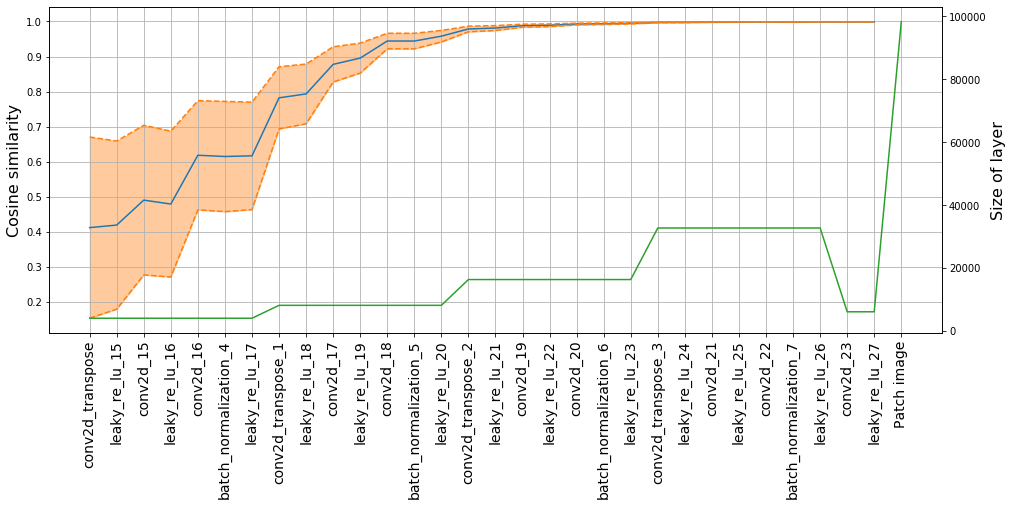

In [163]:
cossim_plot(decoder_layer_mean,decoder_layer_stdv,decoder_results, figsize=(16,6),
           rotation=90,ticksize=14,labelsize=16,savename=f"ri-cossim-decoder-{expname}.pdf")

--------------------------
### Visalization of angle wise cosine similarity

- Decoder

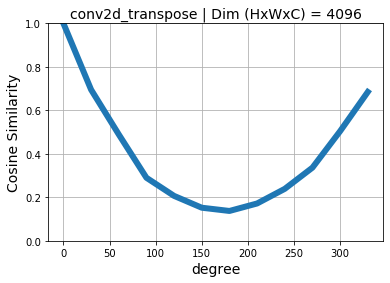

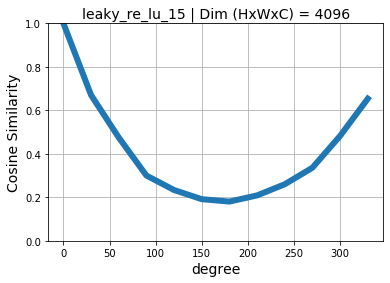

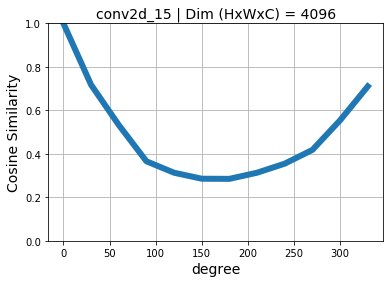

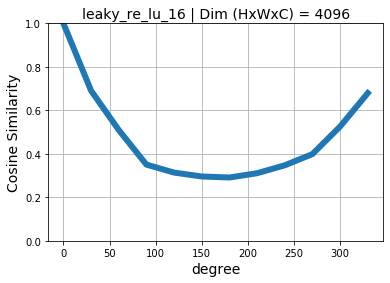

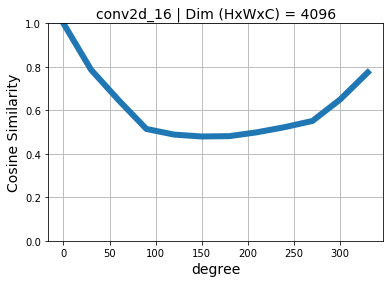

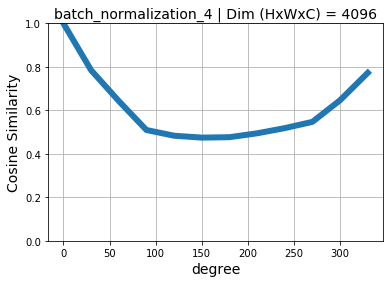

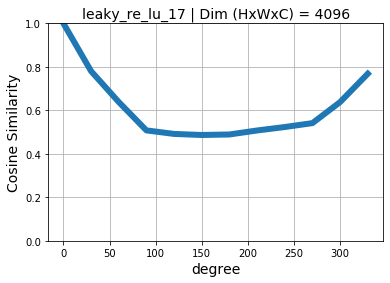

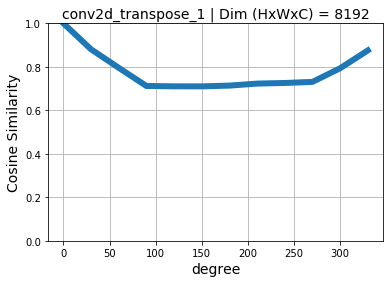

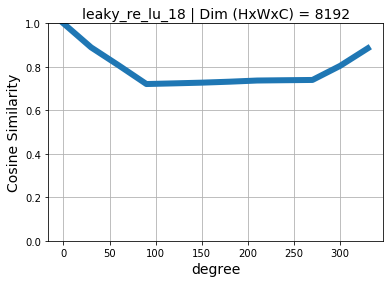

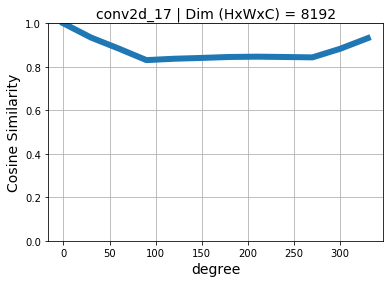

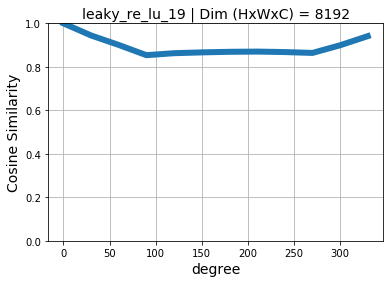

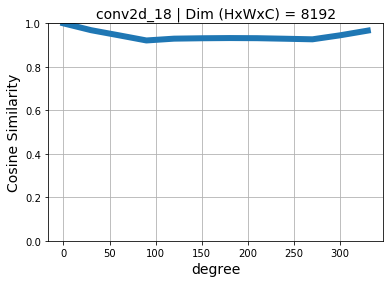

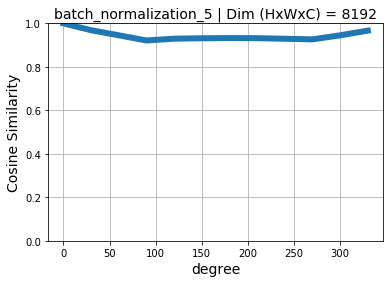

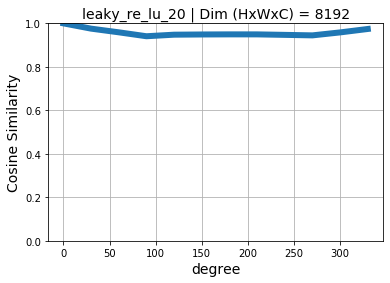

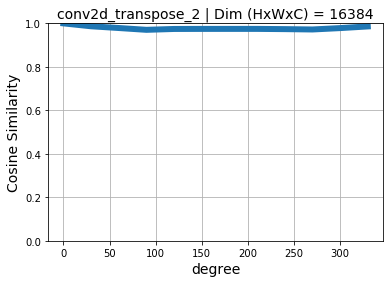

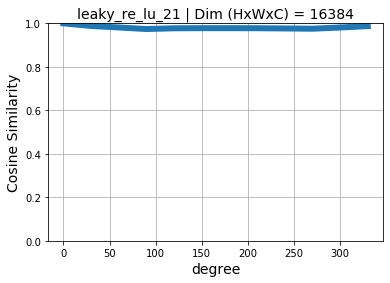

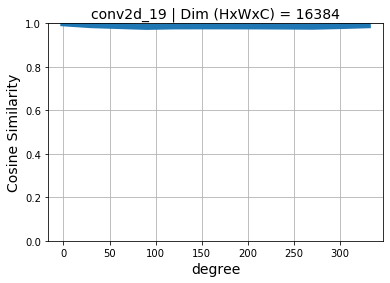

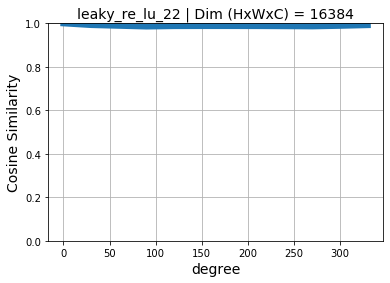

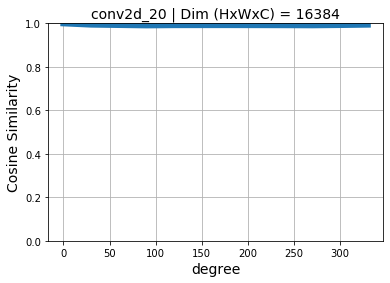

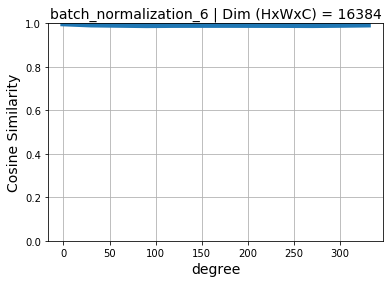

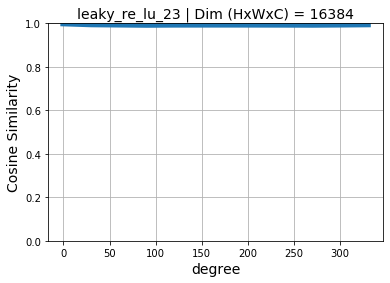

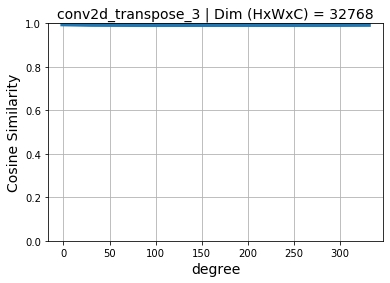

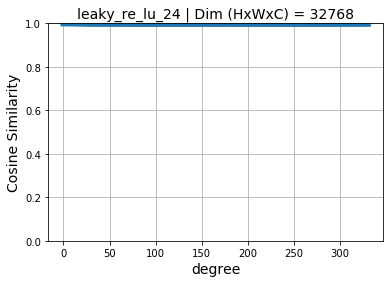

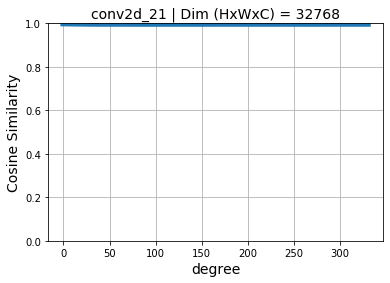

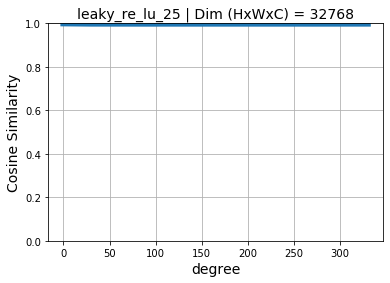

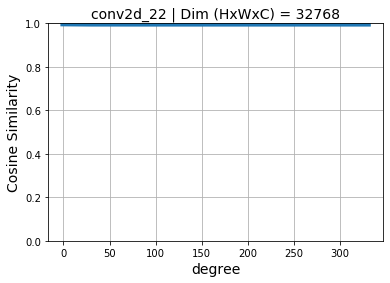

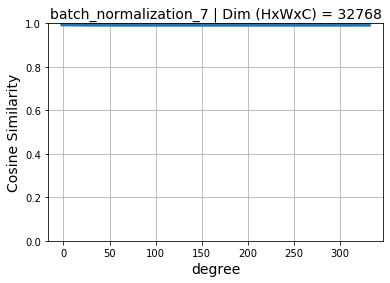

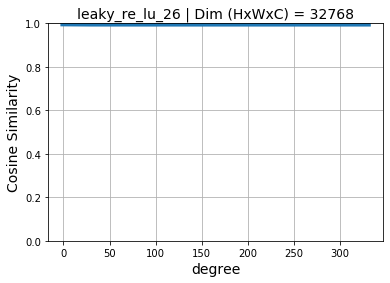

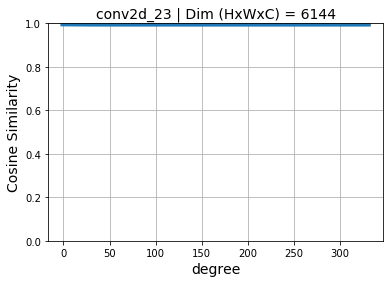

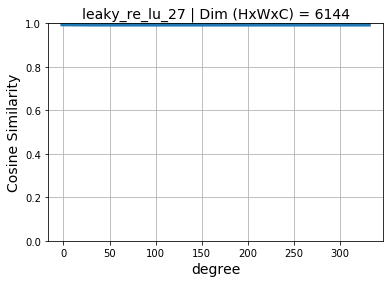

In [54]:
copy_size = 12
x = np.linspace(0,360,copy_size+1)[:-1]
for ikey in results.keys():
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, deg_mean_list[ikey], linewidth=6)
    _,h,w,c = decoder_results[ikey].shape
    plt.title(f"{ikey} | Dim (HxWxC) = {h*w*c}", fontsize=14)
    plt.xlabel('degree', fontsize=14)
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.ylim(0,1.)
    plt.grid(True)
    plt.show()
    plt.close()

## Memo:
Try `leaky_re_lu_23`? Since the layer shows almost rotate-invariant from the consine similarity perspective

-------------------------
- Encoder

In [50]:
# TODO: debug 99 --> 100 since we stored 100 files
encoder_deg_mean_list = {}
for ikey in encoder_cos_results.keys():
    encoder_deg_mean_list[ikey] =  comp_means(encoder_cos_results, ikey=ikey)

In [61]:
encoder_deg_mean_list.keys()

dict_keys(['conv2d', 'leaky_re_lu', 'conv2d_1', 'leaky_re_lu_1', 'conv2d_2', 'leaky_re_lu_2', 'conv2d_3', 'batch_normalization', 'leaky_re_lu_3', 'conv2d_4', 'leaky_re_lu_4', 'conv2d_5', 'leaky_re_lu_5', 'conv2d_6', 'batch_normalization_1', 'leaky_re_lu_6', 'conv2d_7', 'leaky_re_lu_7', 'conv2d_8', 'leaky_re_lu_8', 'conv2d_9', 'batch_normalization_2', 'leaky_re_lu_9', 'conv2d_10', 'leaky_re_lu_10', 'conv2d_11', 'leaky_re_lu_11', 'conv2d_12', 'batch_normalization_3', 'leaky_re_lu_12', 'conv2d_13', 'leaky_re_lu_13', 'conv2d_14', 'leaky_re_lu_14'])

In [64]:
len(encoder_results['conv2d'])

99

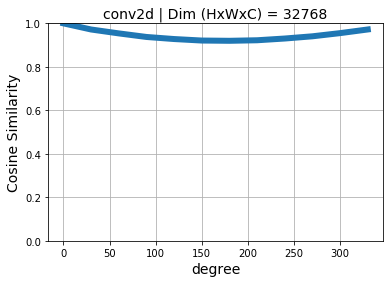

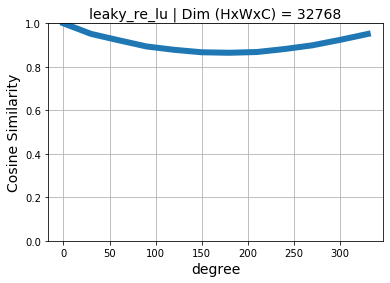

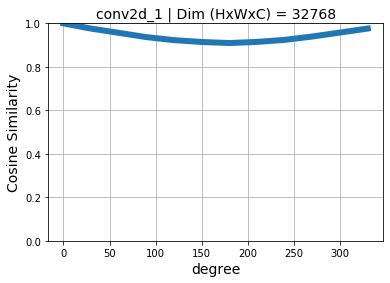

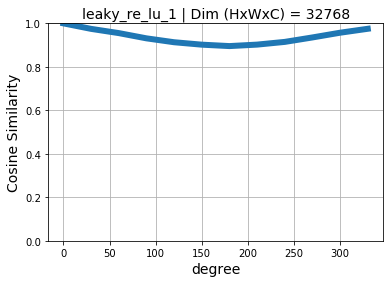

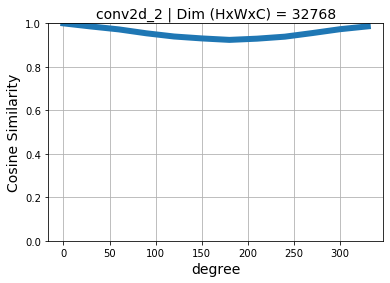

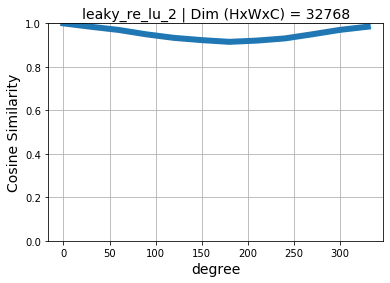

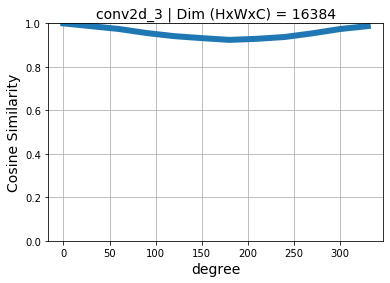

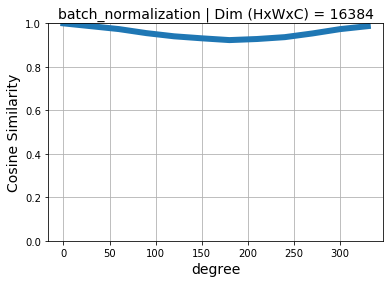

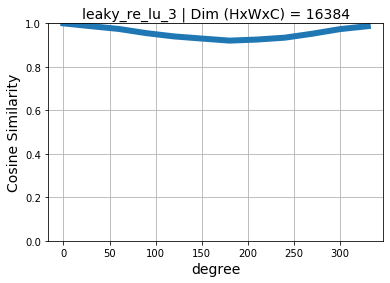

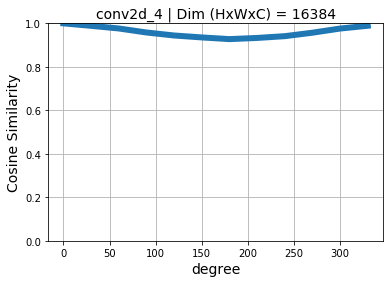

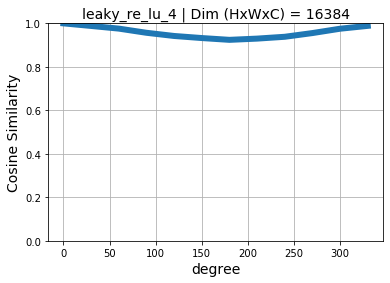

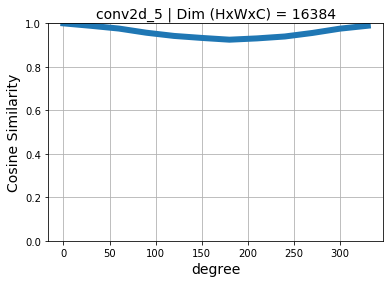

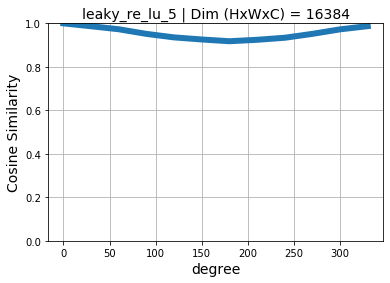

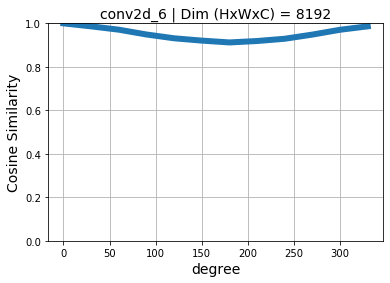

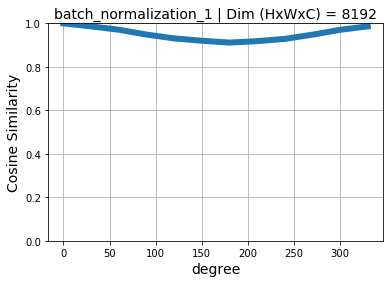

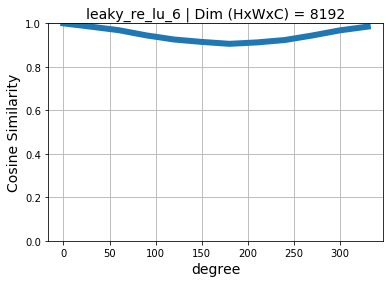

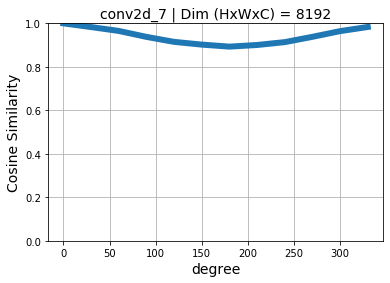

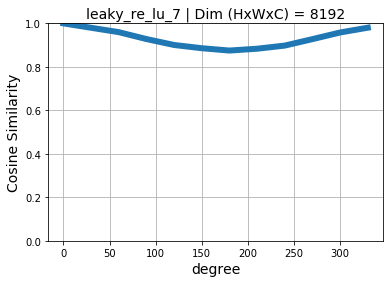

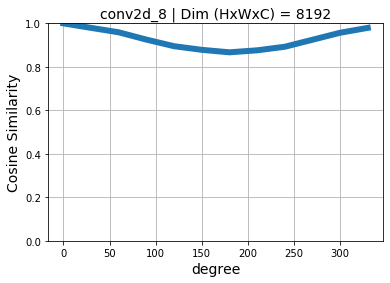

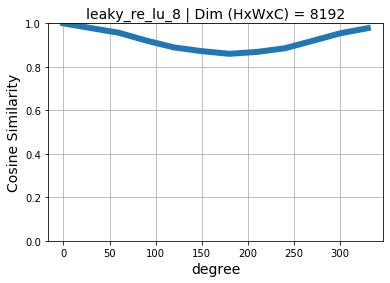

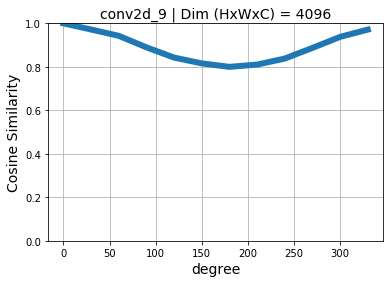

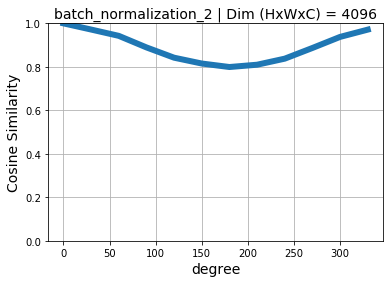

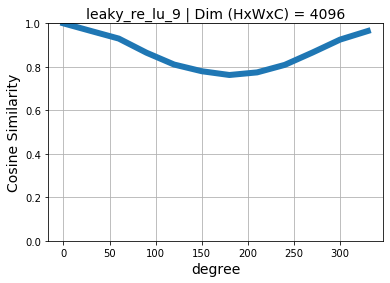

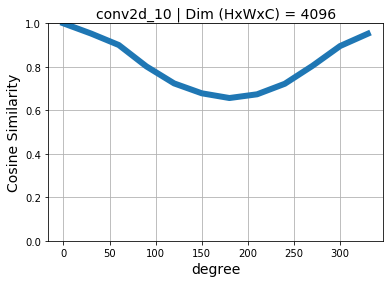

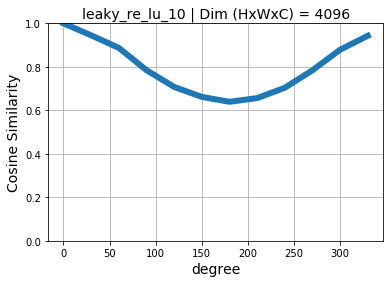

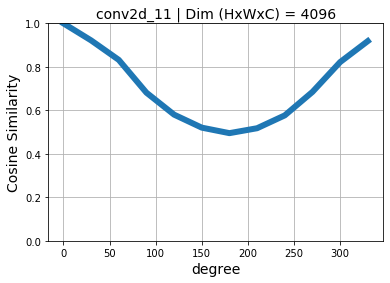

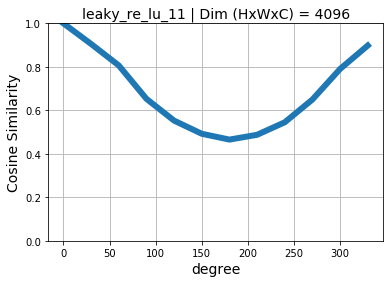

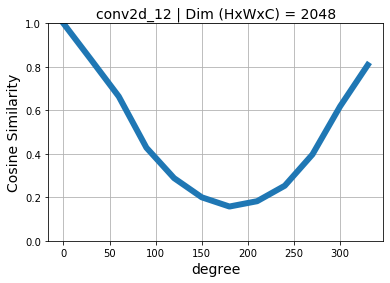

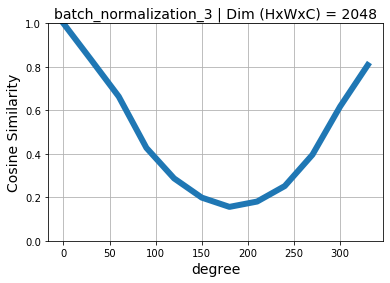

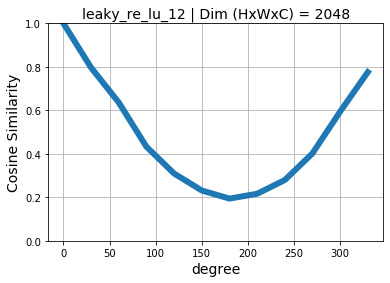

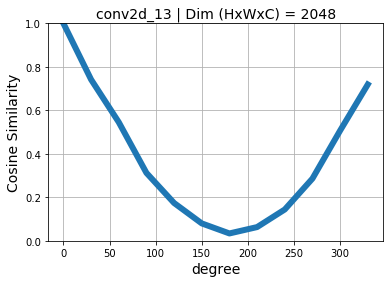

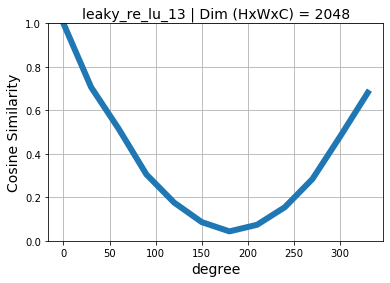

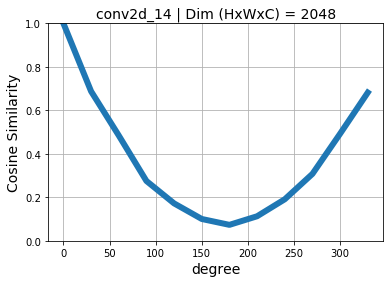

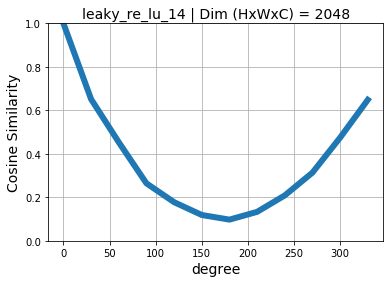

In [69]:
copy_size = 12
x = np.linspace(0,360,copy_size+1)[:-1]
for ikey in encoder_cos_results.keys():
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, encoder_deg_mean_list[ikey], linewidth=6)
    _,h,w,c = encoder_results[ikey].shape
    plt.title(f"{ikey} | Dim (HxWxC) = {h*w*c}", fontsize=14)
    plt.xlabel('degree', fontsize=14)
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.ylim(0,1.)
    plt.grid(True)
    plt.show()
    plt.close()

------------------
### Test on NRI to check cosine similarty

#### Load dataset

In [8]:
tf_datadir = "/project2/foster/clouds/data/clouds_laads_rawdecoded_2000_2018"
filelist = glob.glob(os.path.join(tf_datadir, '2-10*.tfrecord'))

In [10]:
## load 
nfiles = 1
height = width = 128
channel = 6
fdx = np.random.randint(0,len(filelist),nfiles)
patches_list = []
for ifile in [filelist[i] for i in fdx]:
    patches_list.append(data_extractor_resize_fn([ifile],height=height,width=width,channel=6 ))
print("NORMAL END")

## get patch
patches = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,height,width, channel) for i in patches_list[0]],
    axis=0)
print(patches.shape)

OutOfRage --> finish process
NORMAL END
(2000, 128, 128, 6)


#### Load Encoder and Decoder

In [12]:
# m2_02_global_2000_2018_band28_29_31 ; NRI model
model_datadir = '/home/tkurihana/rotate_invariant/stepbystep/transform/output_model'
expname = "m2_02_global_2000_2018_band28_29_31"
model_dir = os.path.join(model_datadir,str(expname) )
encoder = load_latest_model(model_dir, mtype='encoder')
decoder = load_latest_model(model_dir, mtype='decoder')

 Load encoder at 100000 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:891: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)



 Load decoder at 100000 epoch


#### Select patches

In [16]:
spatches = patches[:10] # Decrease size for memoery
spatches.shape

(10, 128, 128, 6)

#### Copy and Rotate

In [17]:
#### CONFIG ####
_, h,w,c, = spatches.shape
copy_size = 12

In [18]:
rpatches = copy_rot_fn(spatches, height=h, width=w, ch=c, copy_size=copy_size)
rpatches.shape

(120, 128, 128, 6)
120


(120, 128, 128, 6)

### Investigate "Invariance" layers
#### Get layers from decoder where rotation invariant is acheived

In [19]:
decoder_results = {}
model = decoder

### processing ###
layer_names = [layer.name for layer in model.layers]
encs = encoder.predict(rpatches)
for layer_name in layer_names[1:]:
    tmp = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
    decoder_results[layer_name] = tmp.predict(encs)

In [20]:
### Check layer sizes
for ikey in decoder_results.keys():
    print(decoder_results[ikey].shape)

(120, 8, 8, 128)
(120, 16, 16, 128)
(120, 16, 16, 128)
(120, 16, 16, 128)
(120, 16, 16, 128)
(120, 16, 16, 128)
(120, 16, 16, 128)
(120, 32, 32, 64)
(120, 32, 32, 64)
(120, 32, 32, 64)
(120, 32, 32, 64)
(120, 32, 32, 64)
(120, 32, 32, 64)
(120, 64, 64, 32)
(120, 64, 64, 32)
(120, 64, 64, 32)
(120, 64, 64, 32)
(120, 64, 64, 32)
(120, 64, 64, 32)
(120, 128, 128, 16)
(120, 128, 128, 16)
(120, 128, 128, 16)
(120, 128, 128, 16)
(120, 128, 128, 16)
(120, 128, 128, 16)
(120, 128, 128, 6)


In [21]:
#https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict
with open('nri_decoder_results_10.pkl', 'wb') as handle:
    pickle.dump(decoder_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Get layers from Encoder: To check cosine similarity

In [22]:
encoder_results = {}
model = encoder

### processing ###
layer_names = [layer.name for layer in model.layers]
#encs = encoder.predict(rpatches)
for layer_name in layer_names[1:]:
    tmp = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
    encoder_results[layer_name] = tmp.predict(rpatches)

In [23]:
### Check layer sizes
for ikey in encoder_results.keys():
    print(encoder_results[ikey].shape)

(120, 128, 128, 16)
(120, 128, 128, 16)
(120, 64, 64, 16)
(120, 64, 64, 16)
(120, 64, 64, 16)
(120, 64, 64, 16)
(120, 64, 64, 16)
(120, 64, 64, 16)
(120, 32, 32, 32)
(120, 32, 32, 32)
(120, 32, 32, 32)
(120, 32, 32, 32)
(120, 32, 32, 32)
(120, 32, 32, 32)
(120, 16, 16, 64)
(120, 16, 16, 64)
(120, 16, 16, 64)
(120, 16, 16, 64)
(120, 16, 16, 64)
(120, 16, 16, 64)
(120, 8, 8, 128)
(120, 8, 8, 128)
(120, 8, 8, 128)
(120, 8, 8, 128)
(120, 8, 8, 128)


In [24]:
with open('nri_encoder_results_10.pkl', 'wb') as handle:
    pickle.dump(encoder_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load computed cosine similarity results

In [61]:
with open('./nri_decoder_cossim_results_10.pkl', 'rb') as handle:
    dresults = pickle.load(handle)

In [62]:
with open('./nri_encoder_cossim_results_10.pkl', 'rb') as handle:
    eresults = pickle.load(handle)

#### Compute average over degree for each layer

In [63]:
# TODO: debug 99 --> 100 since we stored 100 files
deg_mean_list = {}
for ikey in dresults.keys():
    deg_mean_list[ikey] =  comp_means(dresults, ikey=ikey)

- Decoder

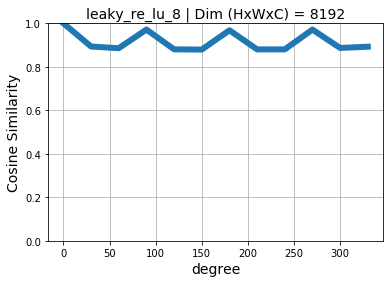

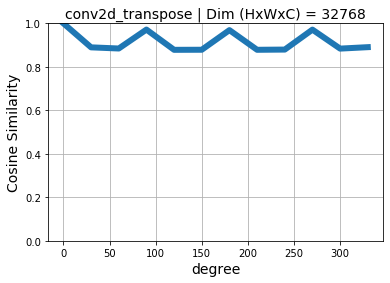

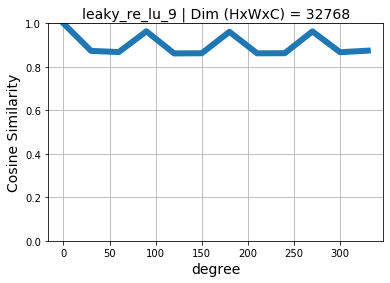

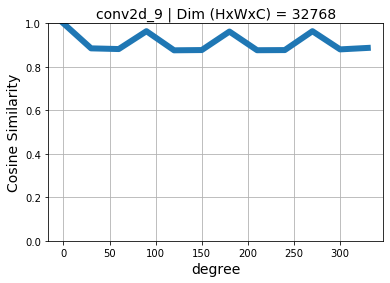

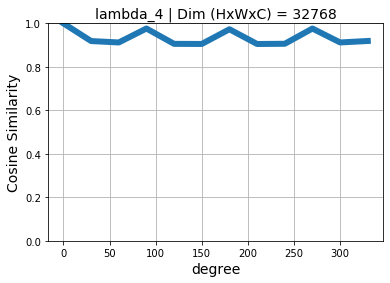

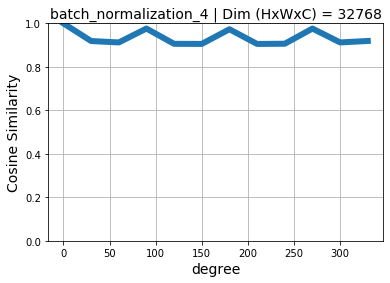

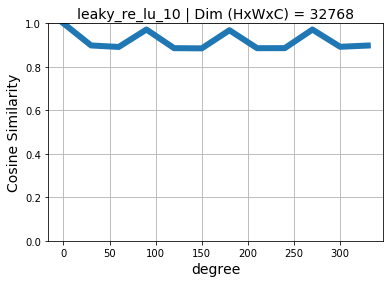

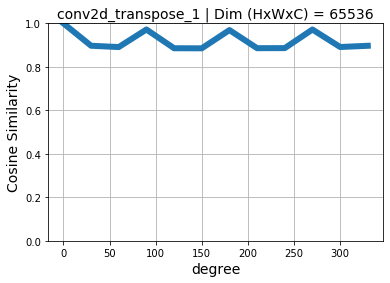

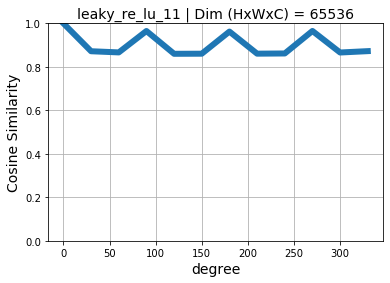

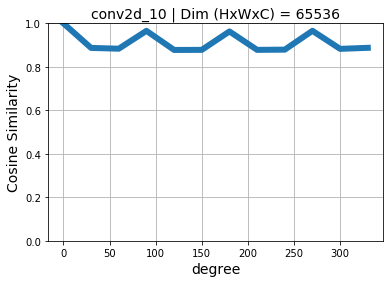

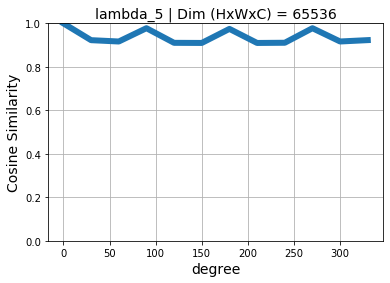

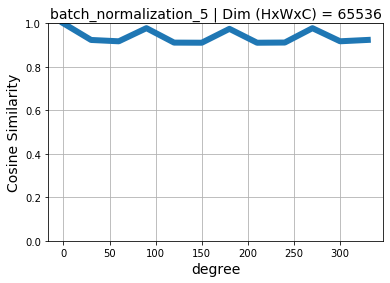

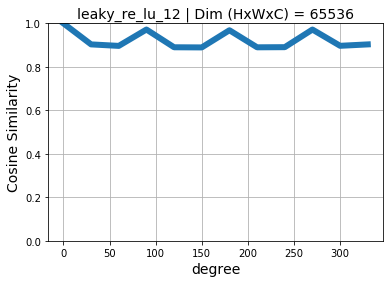

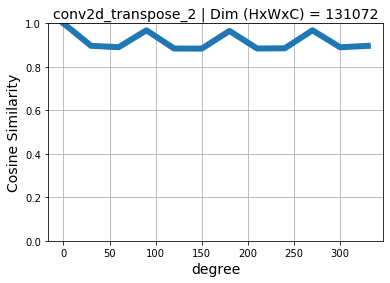

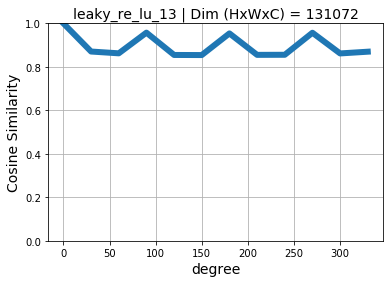

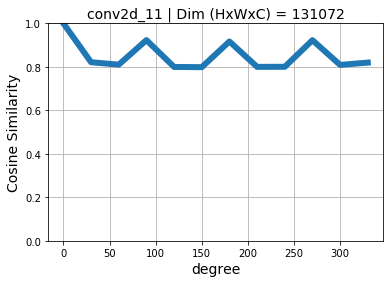

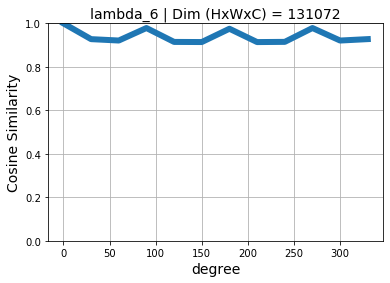

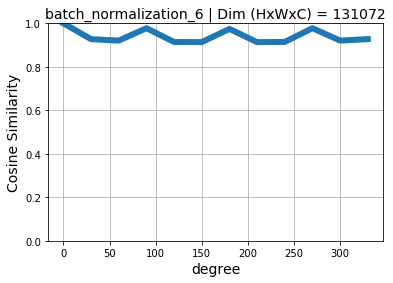

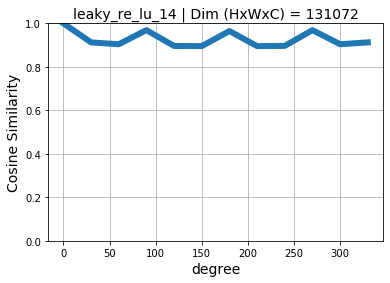

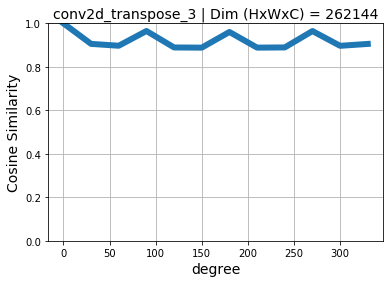

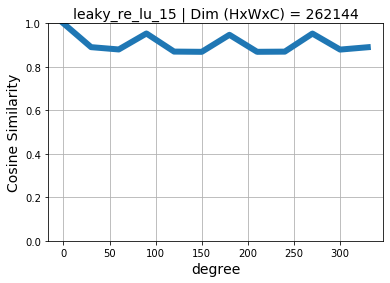

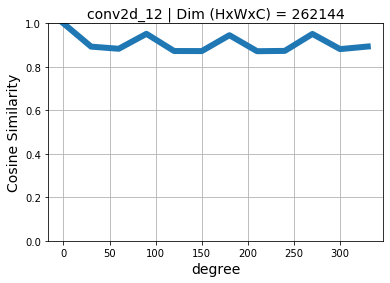

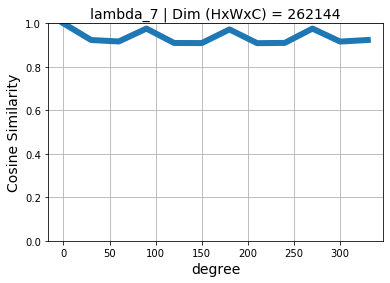

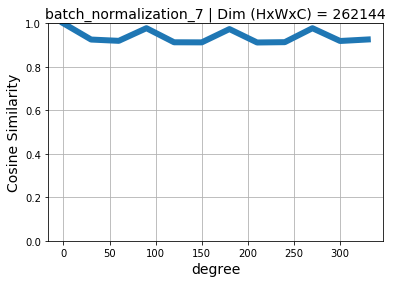

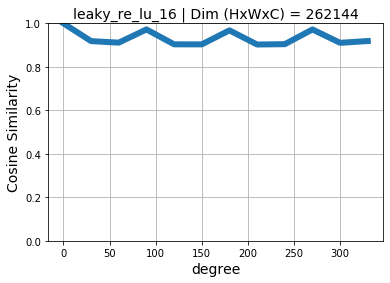

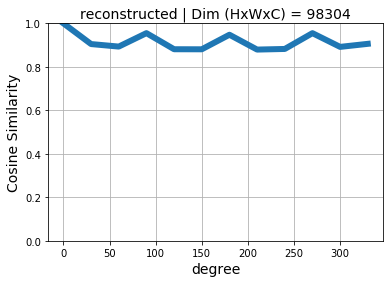

In [31]:
copy_size = 12
x = np.linspace(0,360,copy_size+1)[:-1]
for ikey in dresults.keys():
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, deg_mean_list[ikey], linewidth=6)
    _,h,w,c = decoder_results[ikey].shape
    plt.title(f"{ikey} | Dim (HxWxC) = {h*w*c}", fontsize=14)
    plt.xlabel('degree', fontsize=14)
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.ylim(0,1.)
    plt.grid(True)
    plt.show()
    plt.close()

##### Encoder

In [64]:
encoder_deg_mean_list = {}
for ikey in eresults.keys():
    encoder_deg_mean_list[ikey] =  comp_means(eresults, ikey=ikey)

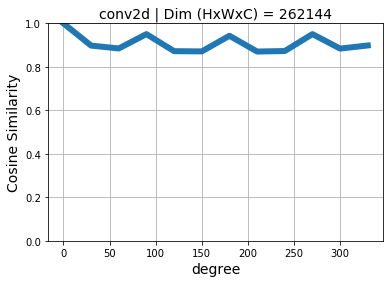

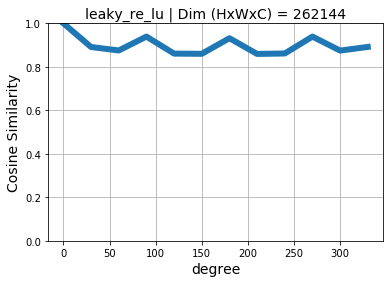

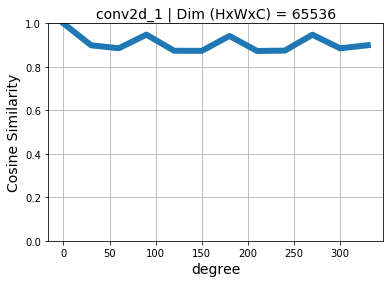

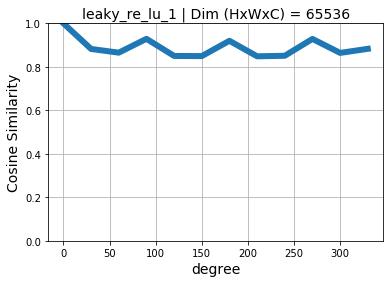

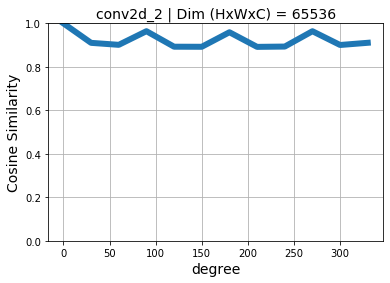

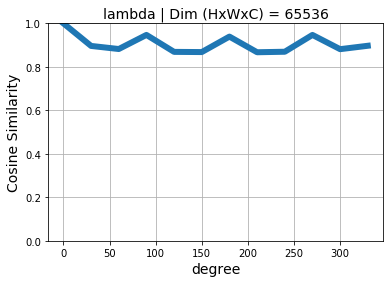

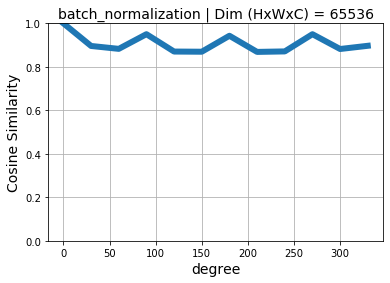

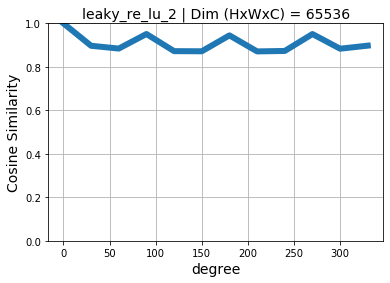

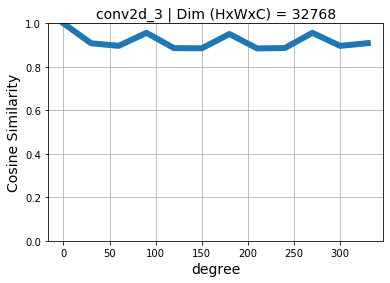

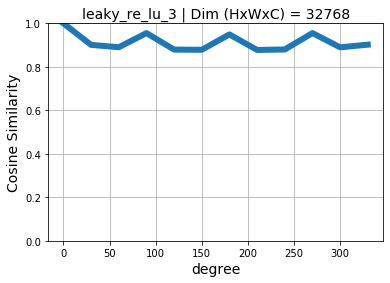

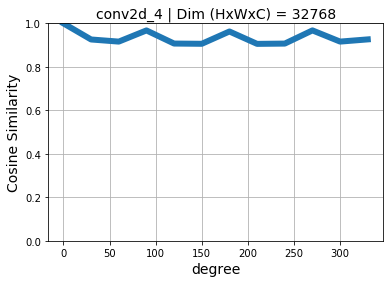

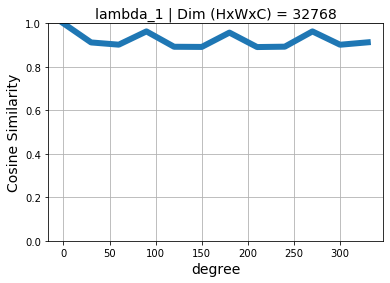

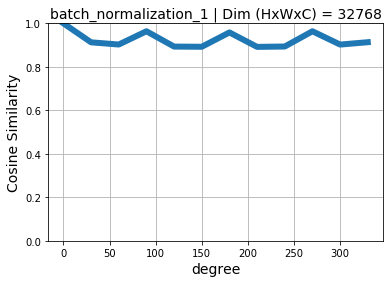

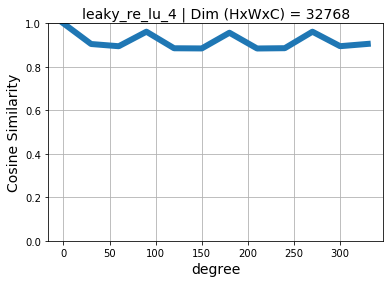

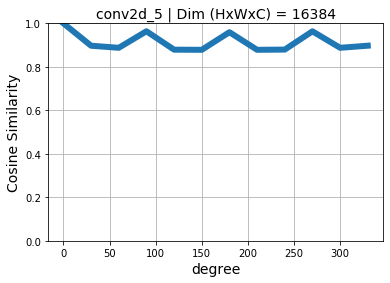

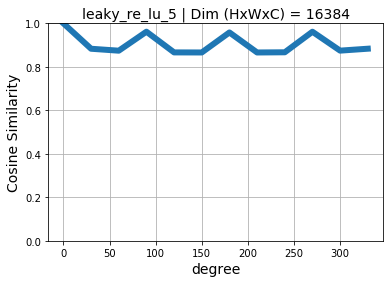

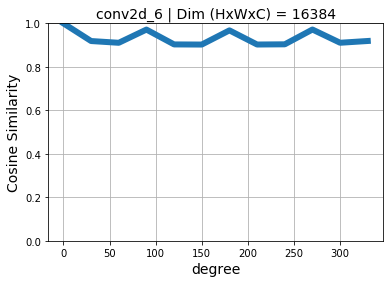

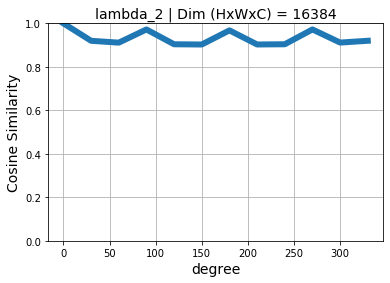

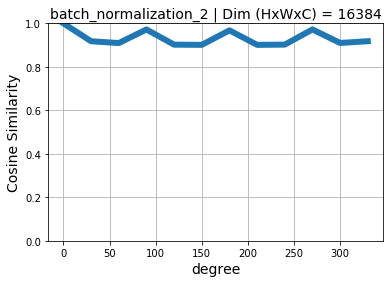

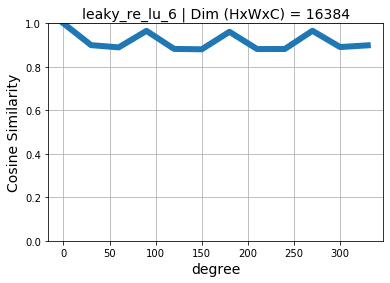

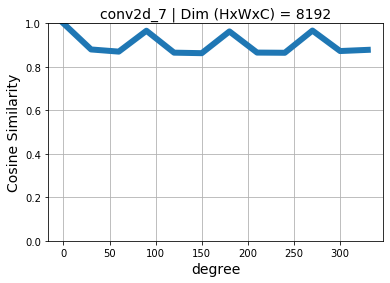

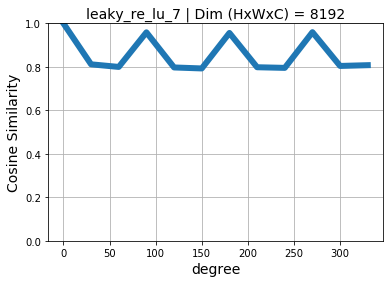

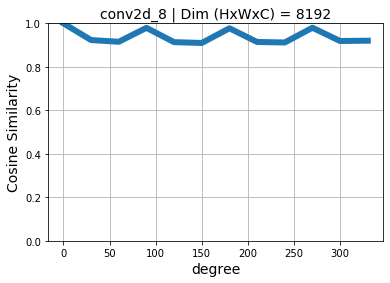

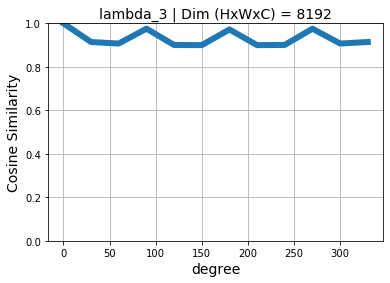

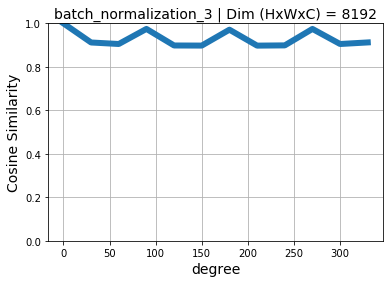

In [33]:
copy_size = 12
x = np.linspace(0,360,copy_size+1)[:-1]
for ikey in eresults.keys():
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, encoder_deg_mean_list[ikey], linewidth=6)
    _,h,w,c = encoder_results[ikey].shape
    plt.title(f"{ikey} | Dim (HxWxC) = {h*w*c}", fontsize=14)
    plt.xlabel('degree', fontsize=14)
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.ylim(0,1.)
    plt.grid(True)
    plt.show()
    plt.close()

------------------
### Make figures to express the transition of cosine similarity

In [34]:
from pylab import *
def get_colors(cmap_name=None, ndiv=-1):
    cmap = cm.get_cmap(cmap_name, ndiv)    # PiYG
    colors = []
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        colors.append(matplotlib.colors.rgb2hex(rgb))
    return colors

##### RI

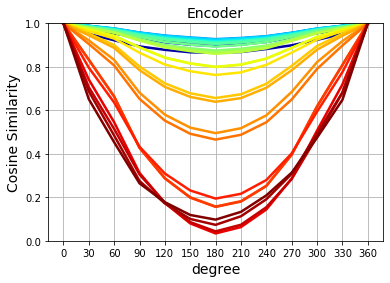

In [59]:
copy_size = 12
fig = plt.figure(figsize=(6,4))
x = np.linspace(0,360,copy_size+1)
colors = get_colors('jet', len(encoder_cos_results.keys()))
for idx, ikey in enumerate(encoder_cos_results.keys()):
    plt.plot(x, np.append(encoder_deg_mean_list[ikey],[1]), linewidth=2.5,color=colors[idx], label=f"{idx}th layer")
plt.title("Encoder", fontsize=14)
plt.xticks(x)
plt.xlabel('degree', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
plt.ylim(0,1.)
#plt.legend(ncol=4)
plt.grid(True)
plt.show()
plt.close()

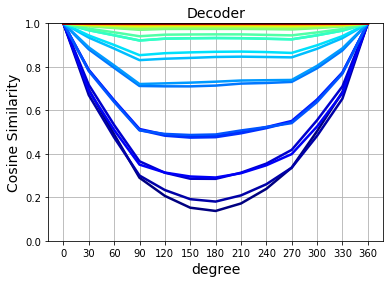

In [60]:
copy_size = 12
fig = plt.figure(figsize=(6,4))
x = np.linspace(0,360,copy_size+1)
colors = get_colors('jet', len(results.keys()))
for idx, ikey in enumerate(results.keys()):
    plt.plot(x, np.append(deg_mean_list[ikey],[1]), linewidth=2.5,color=colors[idx], label=f"{idx}th layer")
plt.title("Decoder", fontsize=14)
plt.xticks(x)
plt.xlabel('degree', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
plt.ylim(0,1.)
#plt.legend(ncol=4)
plt.grid(True)
plt.show()
plt.close()

##### NRI

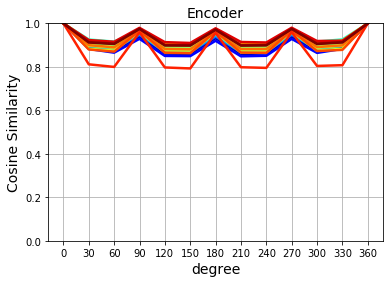

In [68]:
copy_size = 12
fig = plt.figure(figsize=(6,4))
x = np.linspace(0,360,copy_size+1)
colors = get_colors('jet', len(eresults.keys()))
for idx, ikey in enumerate(eresults.keys()):
    plt.plot(x, np.append(encoder_deg_mean_list[ikey],[1]), linewidth=2.5,color=colors[idx], label=f"{idx}th layer")
plt.title("Encoder", fontsize=14)
plt.xlabel('degree', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
plt.ylim(0,1.)
plt.xticks(x)
#plt.legend(ncol=4)
plt.grid(True)
plt.show()
plt.close()

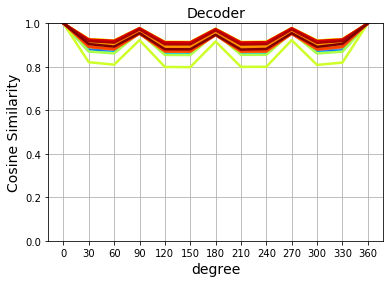

In [67]:
copy_size = 12
fig = plt.figure(figsize=(6,4))
x = np.linspace(0,360,copy_size+1)
colors = get_colors('jet', len(dresults.keys()))
for idx, ikey in enumerate(dresults.keys()):
    plt.plot(x, np.append(deg_mean_list[ikey],[1]), linewidth=2.5,color=colors[idx], label=f"{idx}th layer")
plt.title("Decoder", fontsize=14)
plt.xlabel('degree', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
plt.ylim(0,1.)
plt.xticks(x)
#plt.legend(ncol=4)
plt.grid(True)
plt.show()
plt.close()